In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [2]:
dataset = 'cifar10'
model = 't2t_7'
if dataset == 'cifar10':
    min_ic = 52
    max_ic = 73
if dataset == 'cifar100':
    min_ic = 40
    max_ic = 90

In [3]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
with open(dataset+'_'+model+'/'+dataset+'_weighted_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)
        

In [4]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
    if '.pk' in file_name and 'boosted' not in file_name and 'weighted' not in file_name:
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        list_dicts_ours.append(dicts)

cifar10_0.4_results.pk
cifar10_1.5_results.pk
cifar10_0.16_results.pk
cifar10_0.5_results.pk
cifar10_0.3_results.pk
cifar10_1.2_results.pk
cifar10_1.0_results.pk
cifar10_0.2_results.pk
cifar10_0.1_results.pk
cifar10_0.6_results.pk
cifar10_1.1_results.pk
cifar10_0.12_results.pk
cifar10_0.05_results.pk
cifar10_0.14_results.pk
cifar10_0.8_results.pk


In [5]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys = []
    C_keys = []
    for key in metrics.keys():
        if 'cov' in key:
            tokens = key.split('cov')
            alpha = tokens[1]
            prefix = tokens[0]
            cov_key = prefix+'cov'+alpha
            C_key = prefix+'C'+alpha
            cov_keys.append(cov_key)
            C_keys.append(C_key)
    return cov_keys, C_keys
def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
        alpha_val = float(cov_key.split('_')[-1])
        emp_cov = metrics_we_care_about['average'+cov_key]
        #print(emp_cov)
        if 1-emp_cov< requested_alpha:
            if alpha_max < alpha_val:
                alpha_max = alpha_val
                #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        


In [21]:
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys, C_keys = get_all_cov_C(list_dicts_ours[0])
keys_we_want = keys_we_want + cov_keys + C_keys
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')
keys_we_want = keys_we_want+keys_all_acc+keys_gated_accs

In [22]:
requested_alpha = 0.06

In [23]:
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        metrics_we_care_about['alpha'+cov_key] = float(cov_key.split('_')[-1]) 
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
    if alpha_max >0 :
        C_key = 'test/C_'+str(alpha_max)
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)

ValueError: All arrays must be of the same length

In [ ]:
boosted_cov_keys, boosted_C_keys = get_all_cov_C(list_dict_boosted[0])

boosted_df = pd.DataFrame()
for metrics in list_dict_boosted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    boosted_df = pd.concat([df, boosted_df],axis=0, ignore_index=True)

In [24]:
weighted_cov_keys, weighted_C_keys = get_all_cov_C(list_dict_boosted[0])

weighted_df = pd.DataFrame()
for metrics in list_dict_weighted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    weighted_df = pd.concat([df, weighted_df],axis=0, ignore_index=True)

KeyError: 'alphaC_0.01'

In [25]:
filtered_boosted_df = boosted_df[boosted_df['average_IC'].between(min_ic, max_ic)]
filtered_our_df = our_df[our_df['average_IC'].between(min_ic, max_ic)]
filtered_weighted_df = weighted_df[weighted_df['average_IC'].between(min_ic, max_ic)]


KeyError: 'average_IC'

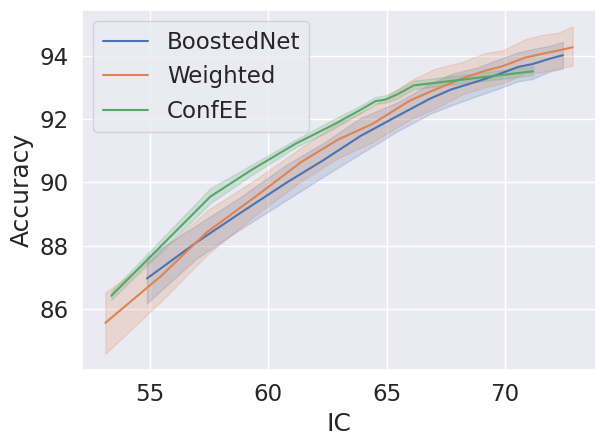

In [26]:
sns.set(font_scale=1.5) 


sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="ACC", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.xlabel('IC')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

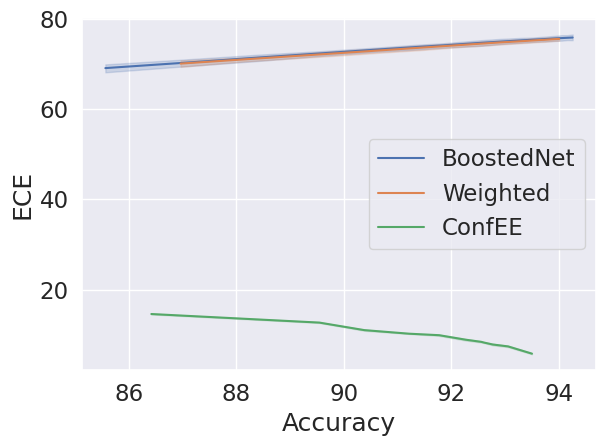

In [27]:
sns.set(font_scale=1.5)  # crazy big
sns.lineplot(data=filtered_weighted_df, x="average_ACC", y="ECE", label="BoostedNet")
sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="ConfEE")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

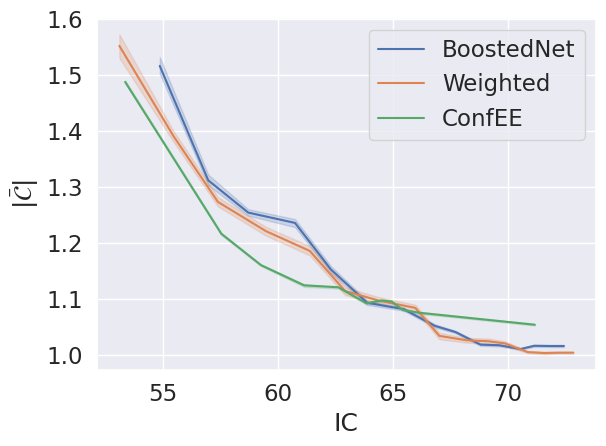

In [28]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="C", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="C", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_IC", y="C", label="ConfEE")

plt.xlabel('IC')
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('inef_IC_'+dataset+'.pdf')


In [29]:
boosted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-boosted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

weighted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-weighted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)
    
our_df_emp_vs_req = pd.DataFrame()

cov_keys_gated = []
cov_keys_gen = []
for c in cov_keys:
    if 'gen' in c:
        cov_keys_gen.append(c)
    else:
        cov_keys_gated.append(c)
for cov_key in cov_keys_gated:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

KeyError: 'cov_0.01'

In [ ]:
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="BoostedNet")
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="Weighted")

sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="ConfEE")
x = [0.01,0.05]
y = [0.01,0.05]
plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('emp_vs_theoritical_'+dataset+'.pdf')


In [ ]:
print(keys_all_acc)
print(keys_gated_accs)

In [33]:

for i, all_acc in enumerate(keys_all_acc):

    print(our_df[all_acc])
    gated_acc = keys_gated_accs[i]
    print(our_df[gated_acc])


0     39.800000
1     41.150000
2     41.100000
3     40.575000
4     40.740000
5     40.266667
6     39.985714
7     40.400000
8     40.311111
9     40.210000
10    39.800000
11    41.150000
12    41.100000
13    40.575000
14    40.740000
15    40.266667
16    39.985714
17    40.400000
18    40.311111
19    40.210000
20    39.800000
21    41.150000
22    41.100000
23    40.575000
24    40.740000
25    40.266667
26    39.985714
27    40.400000
28    40.311111
29    40.210000
30    39.800000
31    41.150000
32    41.100000
33    40.575000
34    40.740000
35    40.266667
36    39.985714
37    40.400000
38    40.311111
39    40.210000
40    39.800000
41    41.150000
42    41.100000
43    40.575000
44    40.740000
45    40.266667
46    39.985714
47    40.400000
48    40.311111
49    40.210000
50    39.800000
51    41.150000
52    41.100000
53    40.575000
54    40.740000
55    40.266667
56    39.985714
57    40.400000
58    40.311111
59    40.210000
Name: test/acc0, dtype: float64
0     72

IndexError: list index out of range

,test/acc0,test/acc1,test/acc2,test/acc3,test/acc4,test/acc5,test/C_0.01,test/cov_0.01,test/C_0.015,test/cov_0.015,...,averagetest/gen_C_0.02,averagetest/gen_C_0.025,averagetest/gen_C_0.03,averagetest/gen_C_0.035,averagetest/gen_C_0.04,averagetest/gen_C_0.045,averagetest/gen_C_0.05,C,emp_alpha,test/gated_acc_5
0,39.800000,52.600000,65.700000,83.400000,92.400000,94.200000,3.890000,0.988000,3.484000,0.986000,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.369000,0.040,NaN
1,41.150000,54.000000,67.650000,83.550000,92.950000,94.950000,3.892500,0.987500,3.486000,0.984500,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.384500,0.040,NaN
2,41.100000,54.233333,68.333333,83.766667,92.300000,94.533333,3.905667,0.984667,3.499000,0.978333,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.367667,0.040,NaN
3,40.575000,53.900000,67.375000,83.375000,92.000000,94.625000,3.899500,0.984500,3.493250,0.977750,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.366750,0.040,NaN
4,40.740000,54.500000,67.820000,83.420000,91.920000,94.620000,3.901600,0.984400,3.496000,0.978600,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.374400,0.040,NaN
5,40.266667,53.950000,67.400000,83.633333,91.683333,94.466667,3.904000,0.984000,3.502000,0.977833,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.370500,0.040,NaN
6,39.985714,53.342857,66.985714,83.528571,91.828571,94.628571,3.907143,0.984714,3.501571,0.978857,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.369000,0.040,NaN
7,40.400000,53.587500,67.350000,83.587500,91.837500,94.537500,3.914875,0.985000,3.509125,0.979125,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.372250,0.040,NaN
8,40.311111,53.355556,67.100000,83.744444,91.877778,94.600000,3.920778,0.985222,3.513889,0.978889,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.372778,0.040,NaN
9,40.210000,53.310000,67.220000,83.680000,91.870000,94.640000,3.921600,0.985400,3.518100,0.979500,...,1.321511,1.172295,1.081803,1.002606,0.915967,0.796358,0.659636,2.375000,0.040,NaN
